In [68]:
from vmad import Builder
from vmad import autooperator
from vmad import operator
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.misc import derivative
from nbodykit.cosmology import Planck15
from nbodykit.cosmology.power.transfers import NoWiggleEisensteinHu
from vmad.core.stdlib.operators import mul, div, add, sub
from vmad.core.stdlib.operators import pow as power
from vmad.lib.linalg import reshape

import matplotlib.pyplot as plt
%matplotlib notebook

# Einstein Ho no wiggles remixxxx

In [487]:
cosmo = Planck15
cosmo = cosmo.match(sigma8=.8158)
cosmo = cosmo.clone(P_k_max=100)

In [290]:
@operator
class log:
    ain = 'x'
    aout = 'y'

    def apl(node, x):
        return dict(y=np.log(x))

    def vjp(node, _y, x):
        return dict(_x=1 / x * _y)

    def jvp(node, x_, x):
        return dict(y_=1 / x * x_)

\begin{equation}
\delta_H = 1.94\times 10^{-5}\Omega_{m,0}^{-.785-.05ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}
\end{equation}

\begin{equation}
\dfrac{\partial\delta_H}{\partial \Omega_{m,0}} = 1.94\times 10^{-5}\left(-.785 + .05\ln(\Omega_{m,0})\right)\Omega_{m,0}^{-1.785 + .05\ln(\Omega_{m,0})}e^{\tilde{n}+1.97\tilde{n}^2}\dfrac{.05}{\Omega_{m,0}}
\end{equation}

In [441]:
@operator
class amplitude:
    ain = 'omega0_m'
    aout = 'delta_h'

    def apl(node, omega0_m, n):
        factor_1 = 1.94e-5 * omega0_m**(-.785 - .05 * np.log(omega0_m))
        factor_2 = np.e**((n - 1) + 1.97 * (n - 1)**2)

        return dict(delta_h=factor_1 * factor_2)

    def vjp(node, _delta_h, omega0_m, n):
        factor_1 = 1.94e-5*(-.785+.05*np.log(omega0_m))*.05/omega0_m\
                    * omega0_m**(-1.785-.05*np.log(omega0_m))

        factor_2 = np.e**((n - 1) + 1.97 * (n - 1)**2)
        return dict(_omega0_m=factor_1 * factor_2 * _delta_h)

    def jvp(node, omega0_m_, omega0_m, n):
        factor_1 = 1.94e-5*(-.785+.05*np.log(omege0_m))*.05/omega0_m \
                    * omega0_m**(-1.785-.05*np.log(omega0_m))
        factor_2 = np.e**((n - 1) + 1.97 * (n - 1)**2)

        return dict(delta_h_=factor_1 * factor_2 * omega0_m_)

\begin{equation}
    D_1(z) = (1+z)^{-1}\dfrac{5\Omega(z)}{2}\left[\Omega(z)^{4/7}-\Omega_\Lambda(z) +(1+\Omega(z)/2)(1+\Omega_\Lambda(z)/70)\right]^{-1}
\end{equation}

\begin{equation}
\begin{split}
\dfrac{\partial D_1(z)}{\partial \Omega} &= \dfrac{(1+z)^{-1}\dfrac{5}{2}}{\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\left[1 - \dfrac{\Omega(z)\left( 4/7 \Omega (z)^{-3/7}+1/2+\Omega_\Lambda(z)/140\right)}{[\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70)}\right]\\
\dfrac{\partial D_1(z)}{\partial \Omega_\Lambda} &= -\dfrac{5\Omega (z)(-1+1/70+\Omega(z)/140)}{2(1+z)(\Omega (z)^{4/7} - \Omega_\Lambda (z)+(1+\Omega (z)/2)(1+\Omega_\Lambda (z)/70))^2}
\end{split}
\end{equation}


In [442]:
@operator
class growth:
    ain = 'omega_z', 'omega_lambda'
    aout = 'growth'

    def apl(node, omega_z, omega_lambda, z):
        growth = (1 + z)**(-1) * 5 * omega_z / 2 * (
            omega_z**(4 / 7) - omega_lambda + (1 + omega_z / 2) *
            (1 + omega_lambda / 70))**(-1)
        return dict(growth=growth)

    def vjp(node, _growth, omega_z, omega_lambda, z):
        _omega_z = (1+z)**(-1)*5/2*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1)\
                    *(1- omega_z*(4/7*omega_z**(-3/7)+1/2+omega_lambda/140)\
                     *(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1))

        _omega_lambda = 5*omega_z*(-1+1/70+omega_z/140)/(2*(1+z)*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)\
                                                                  *(1+omega_lambda/70))**(-2))
        return dict(_omega_z=_omega_z * _growth,
                    _omega_lambda=_omega_lambda * _growth)

    def jvp(node, omega_z_, omega_lambda_, omega_z, omega_lambda, z):
        omega_z_ *= (1+z)**(-1)*5/2*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1)\
                    *(1- omega_z*(4/7*omega_z**(-3/7)+1/2+omega_lambda/140)\
                     *(omega_z**(4/7)-omega_lambda+(1+omega_z/2)*(1+omega_lambda/70))**(-1))
        omega_lambda_ *= 5*omega_z*(-1+1/70+omega_z/140)/(2*(1+z)*(omega_z**(4/7)-omega_lambda+(1+omega_z/2)\
                                                                  *(1+omega_lambda/70))**(-2))
        return dict(growth_=omega_z_ + omega_lambda_)

\begin{equation}
\Omega(z) = \dfrac{\Omega_0 (1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega(z)}{\partial \Omega_{0}} = \dfrac{(1+z)^3}{\Omega_\Lambda+\Omega_0(1+z)^3}\left[1 - \dfrac{\Omega_0 (1+z)^3}{\left(\Omega_\Lambda+\Omega_0(1+z)^3\right)}\right]
\end{equation}

In [443]:
@operator
class omega_z:
    ain = 'omega0_m'
    aout = 'omega_z'

    def apl(node, omega0_m, z):
        omega0_l = 1 - omega0_m
        return dict(omega_z=omega0_m * (1 + z)**3 / (omega0_l + omega0_m *
                                                     (1 + z)**3))

    def vjp(node, _omega_z, omega0_m, z):
        _omega0_m = (1+z)**3/(1-omega0_m +omega0_m*(1+z)**3)\
                    *(1 - omega0_m*(1+z)**3/(1-omega0_m +omega0_m*(1+z)**3))
        return dict(_omega0_m=_omega0_m * _omega_z)

    def jvp(node, omega0_m_, omega0_m, z):
        omega0_m_ *= (1+z)**3/(omega0_l +omega0_m*(1+z)**3)\
                    *(1 - omega0_m*(1+z)**3/(omega0_l +omega0_m*(1+z)**3))
        return dict(omega_z_=omega0_m_)

\begin{equation}
\Omega_\Lambda(z) = \dfrac{1-\Omega_0}{1-\Omega_0 + \Omega_0(1+z)^3}
\end{equation}

\begin{equation}
\dfrac{\partial \Omega_\Lambda(z)}{\partial \Omega_0} = \dfrac{-1}{1-\Omega_0 +\Omega_0(1+z)^3} - \dfrac{1-\Omega_0(-1+(1+z)^3)}{\left(1-\Omega_0+\Omega_0(1+z)^3\right)^2}
\end{equation}

In [444]:
@operator
class omega_lambda:
    ain = 'omega0_m'
    aout = 'omega_lambda'

    def apl(node, omega0_m, z):
        omega0_l = 1 - omega0_m
        return dict(omega_lambda=omega0_l / (omega0_l + omega0_m * (1 + z)**3))

    def vjp(node, _omega_lambda, omega0_m, z):
        _omega0_m = -1/(1-omega0_m+omega0_m*(1+z)**3)*(1+(1-omega0_m*((1+z)**3-1))\
                                                       /(1-omega0_m +omega0_m*(1+z)**3))
        return dict(_omega0_m=_omega0_m * _omega_lambda)

    def jvp(node, omega0_m_, omega0_m, z):
        omega0_m_ *= -1/(1-omega0_m+omega0_m*(1+z)**3)*(1+(1-omega0_m*((1+z)**3-1))\
                                                       /(1-omega0_m +omega0_m*(1+z)**3))
        return dict(omega_lambda_=omega0_m_)

In [518]:
@autooperator('Omega0_m->Pk')
def get_pklin(Omega0_m, Omega0_b, h, Tcmb0, C, H0, n, z, k):

    Obh2 = Omega0_b * h**2
    Omh2 = mul(Omega0_m, power(h, 2))
    f_baryon = div(Omega0_b, Omega0_m)
    theta_cmb = Tcmb0 / 2.7

    k_eq = mul(mul(0.0746, Omh2), power(theta_cmb, -2))  # units of 1/Mpc

    sound_horizon = div(mul(h * 44.5, log(div(9.83, Omh2))),
                        np.sqrt(1 + 10 * Obh2**0.75))  # in Mpc/h


    alpha_gamma = sub(1, add(mul(mul(0.328, log(431*Omh2)), f_baryon), \
                        mul(mul(0.38, log(22.3*Omh2)), power(f_baryon, 2))))
    k = k * h  # in 1/Mpc now
    ks = mul(k, div(sound_horizon, h))
    q = div(k, mul(13.41, k_eq))

    gamma_eff = mul(
        Omh2, (alpha_gamma +
               div(sub(1, alpha_gamma), add(1, power(mul(0.43, ks), 4)))))
    q_eff = mul(q, div(Omh2, gamma_eff))

    L0 = log(add(mul(2, np.e), mul(1.8, q_eff)))
    C0 = add(14.2, div(731.0, add(1, mul(62.5, q_eff))))

    T = div(L0, add(L0, mul(C0, power(q_eff, 2))))

    ### ADD GROWTH###
    omega_zs = omega_z(Omega0_m, z)
    omega_lambdas = omega_lambda(Omega0_m, z)
    growth_z = growth(omega_zs, omega_lambdas, z)

    ###ADD AMPLITUDE###
    delta_h = amplitude(Omega0_m, n)

    ###ADD FACTOR###
    factor = 2 * np.pi**2 / k**3 * (C * k / H0)**(3 + n)

    Pk = div(
        mul(mul(mul(power(delta_h, 2), power(T, 2)), power(growth_z, 2)),
            factor), h**3)

    return dict(Pk=Pk)

In [520]:
Omega0_b = cosmo.Omega0_b
h = cosmo.h
Tcmb0 = cosmo.Tcmb0
C = cosmo.C
H0 = cosmo.H0
n = cosmo.n_s
k = np.linspace(1e-2, 100, 1e5)
z = 2



p, tape= get_pklin.build(Omega0_b = Omega0_b, h=h, Tcmb0=Tcmb0, C=C, \
                                           H0=H0, n=n, z=z, k=k).compute(init = dict(Omega0_m=cosmo.Omega0_m),\
                                                                         vout='Pk', return_tape=True)

In [521]:
cos_pow = cosmo.get_pklin(k, z)
error = np.abs(p - cos_pow) / cos_pow

In [522]:
cosmo.scale_independent_growth_factor(2)

array(0.41994873)

<IPython.core.display.Javascript object>


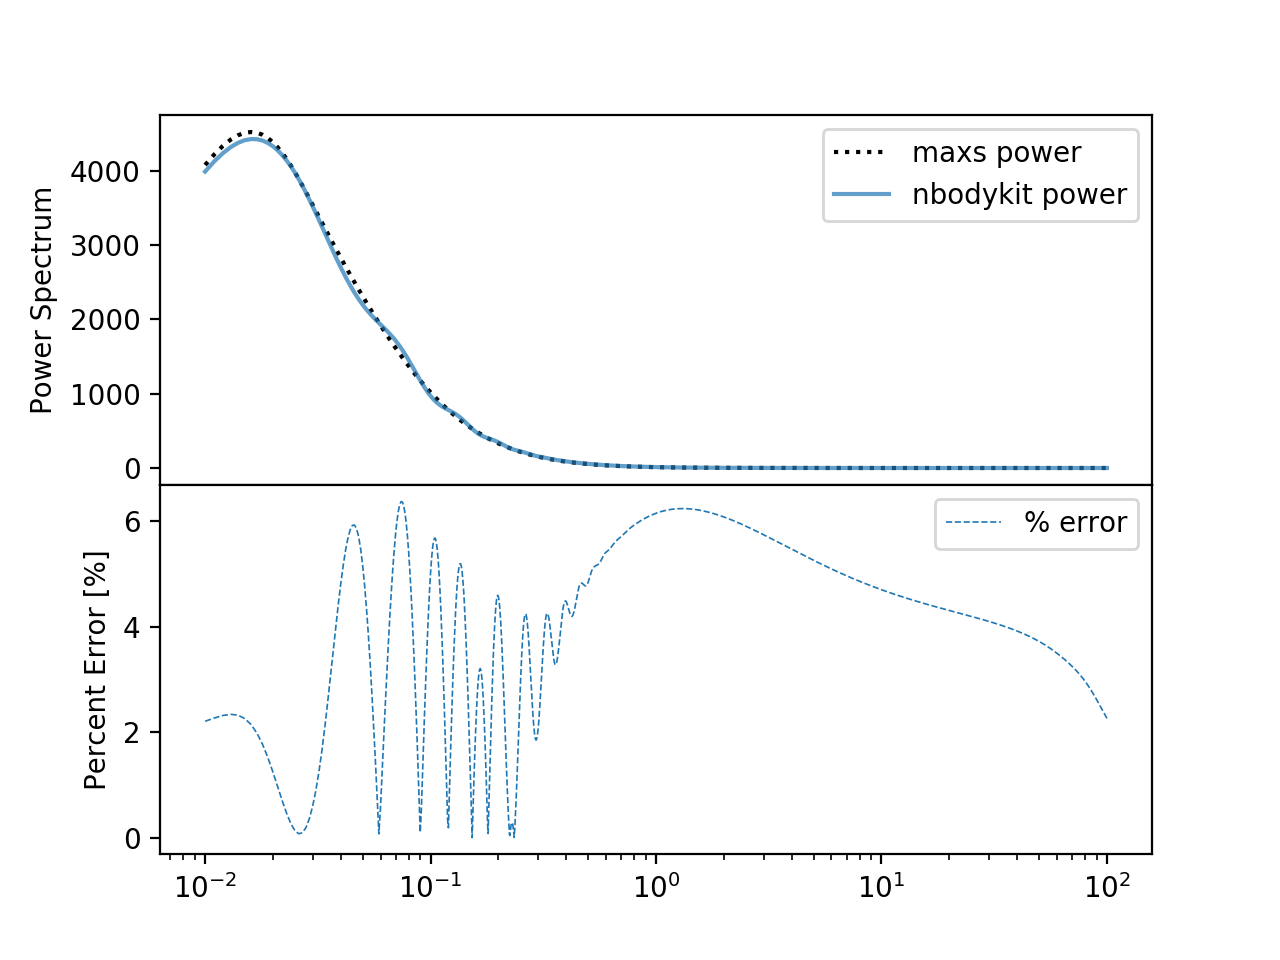

In [529]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace': 0})
ax1.semilogx(k, p, ':k', label='maxs power')
ax1.semilogx(k, cos_pow, label='nbodykit power', alpha=.7)
ax1.set_xlabel('k')
ax1.set_ylabel('Power Spectrum')
ax1.legend()
ax2.semilogx(k, 100*error, '--', label='% error', lw=.6)
ax2.set_ylabel('Percent Error [%]')
ax2.legend()

In [530]:
vjp = tape.get_vjp()
_Omega0_m = vjp.compute(init=dict(_Pk=1), vout='_Omega0_m')

<IPython.core.display.Javascript object>


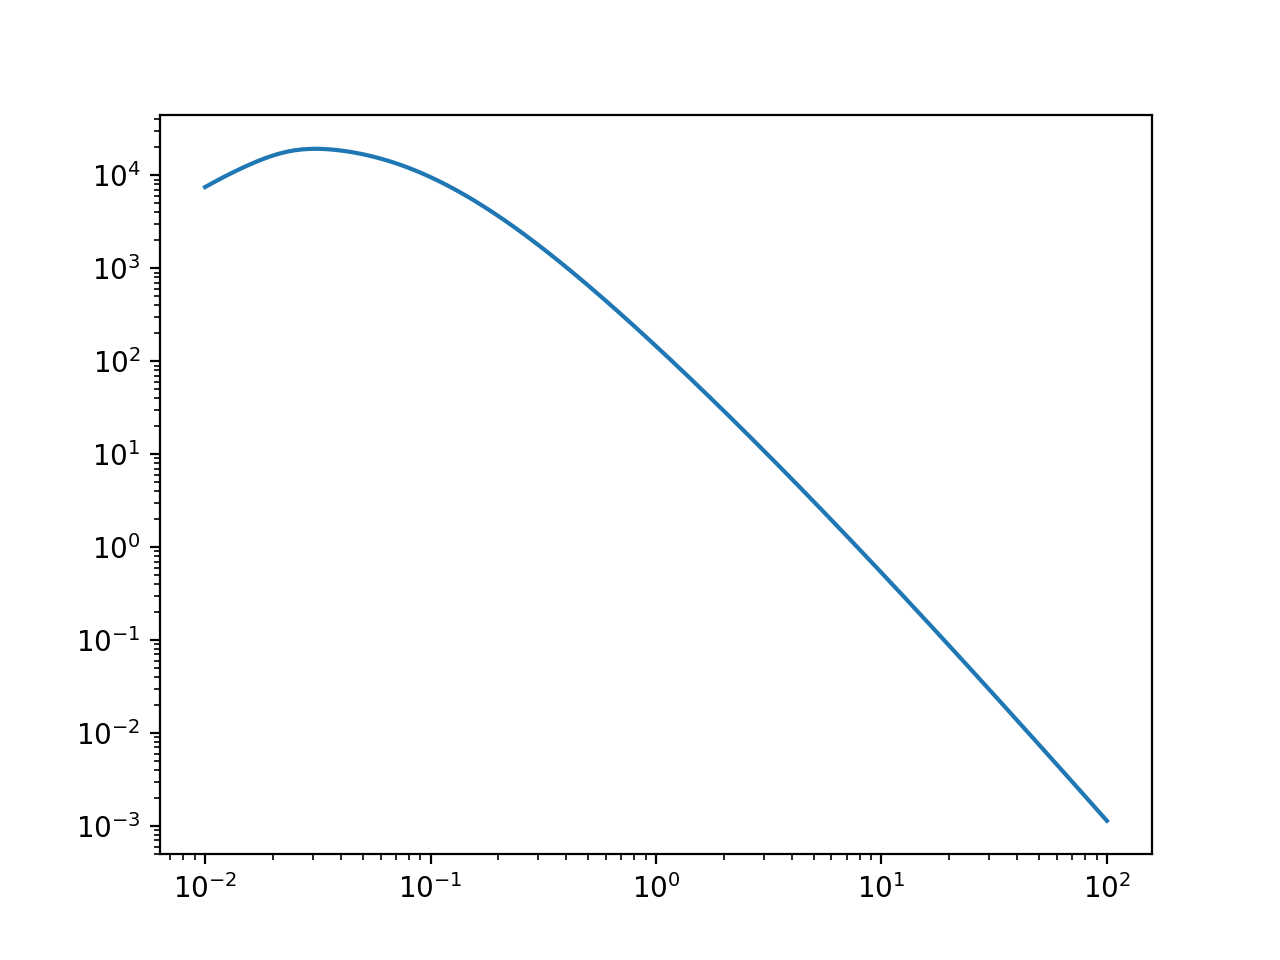

In [531]:
plt.figure()
plt.loglog(k, _Omega0_m)
plt.xlabel('k')
plt.ylabel('\Omega')

In [179]:
cosmo.Omega0_m

0.308

In [73]:
from vmad.lib import fastpm
from mpi4py import MPI

In [151]:
pm = fastpm.ParticleMesh(Nmesh=[128] * 3,
                         BoxSize=[256] * 3,
                         comm=MPI.COMM_WORLD,
                         resampler='cic')

In [152]:
rho = pm.generate_whitenoise(seed=1, unitary=False, type='complex')

In [161]:
pk = rho.apply(lambda k,v:get_pklin.build(Omega0_b = cosmo.Omega0_b, h=cosmo.h, Tcmb0=cosmo.Tcmb0, C=cosmo.C, \
                                    H0=cosmo.H0, n=cosmo.n_s, z=1, k=k).compute(init=dict(Omega0_m = cosmo.Omega0_m), vout='Pk'))

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in power
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in multiply


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

In [155]:
rho       = rho.apply(lambda k, v:)

[array([[ 0.        ,  0.0166259 ,  0.03325179,  0.04987769,  0.06650359,
         0.08312949,  0.09975538,  0.11638128,  0.13300718,  0.14963308,
         0.16625897,  0.18288487,  0.19951077,  0.21613667,  0.23276256,
         0.24938846,  0.26601436,  0.28264026,  0.29926615,  0.31589205,
         0.33251795,  0.34914384,  0.36576974,  0.38239564,  0.39902154,
         0.41564743,  0.43227333,  0.44889923,  0.46552513,  0.48215102,
         0.49877692,  0.51540282,  0.53202872,  0.54865461,  0.56528051,
         0.58190641,  0.59853231,  0.6151582 ,  0.6317841 ,  0.64841   ,
         0.66503589,  0.68166179,  0.69828769,  0.71491359,  0.73153948,
         0.74816538,  0.76479128,  0.78141718,  0.79804307,  0.81466897,
         0.83129487,  0.84792077,  0.86454666,  0.88117256,  0.89779846,
         0.91442436,  0.93105025,  0.94767615,  0.96430205,  0.98092794,
         0.99755384,  1.01417974,  1.03080564,  1.04743153, -1.06405743,
        -1.04743153, -1.03080564, -1.01417974, -0.

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in true_divide
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in power
/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in multiply


TypeError: loop of ufunc does not support argument 0 of type numpy.ndarray which has no callable log method

In [149]:
%debug

> <ipython-input-141-1a360920f121>(18)get_pklin()
     16     alpha_gamma = sub(1, add(mul(mul(0.328, log(431*Omh2)), f_baryon), \
     17                         mul(mul(0.38, log(22.3*Omh2)), power(f_baryon, 2))))
---> 18     k_shape = k.shape
     19     k = np.ndarray.flatten(np.asarray(k)) * h  # in 1/Mpc now
     20     ks = mul(k, div(sound_horizon, h))

ipdb> type(k)
<class 'pmesh.pm.xslab'>
ipdb> exit


In [110]:
A = np.arange(0, 100)
A = A.reshape(10, 5, 2)

In [92]:
%debug

> <ipython-input-10-884da6a75a9d>(7)apl()
      5 
      6     def apl(node, x):
----> 7         return dict(y = np.log(x))
      8     def vjp(node, _y, x):
      9         return dict(_x = 1/x*_y)

ipdb> x
array([array([[  5.43656366,   5.68298865,   5.98309409,   6.26473553,
          6.54277827,   6.82001717,   7.09700413,   7.37389254,
          7.65073613,   7.92755699,   8.20436533,   8.48116633,
          8.75796278,   9.0347563 ,   9.31154786,   9.58833807,
          9.86512733,  10.1419159 ,  10.41870395,  10.69549163,
         10.97227901,  11.24906617,  11.52585315,  11.80263999,
         12.07942672,  12.35621336,  12.63299993,  12.90978643,
         13.18657289,  13.4633593 ,  13.74014568,  14.01693203,
         14.29371835,  14.57050465,  14.84729094,  15.12407721,
         15.40086346,  15.6776497 ,  15.95443593,  16.23122216,
         16.50800837,  16.78479458,  17.06158078,  17.33836698,
         17.61515317,  17.89193936,  18.16872554,  18.44551172,
         18.72229

In [138]:
A= np.ndarray(np.arange(0,10))
A.apply(lambda A: A*3)

AttributeError: 'numpy.ndarray' object has no attribute 'apply'